In [1]:
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import talib as ta

plt.style.use('ggplot')

# warning 非表示
import warnings
warnings.filterwarnings('ignore')

# https://kabuoji3.com/stock/

# 1. download 
stock0 = "/tmp/7201_2018.csv" #NISSAN
stock1 = "/tmp/6758_2018.csv" #SONY
stock2 = "/tmp/3436_2018.csv" #SUMCO
stock3 = "/tmp/8306_2018.csv" #MUFG


In [2]:
# 2.csv を dataframe にしてください。
# その時DateTime型や数値型になっている事をキチンと確認してください。

def csv_to_df(fname):
    df = pd.read_csv(fname, 
                     skiprows=[0], 
                     encoding='shift-jis', 
                     index_col="日付", 
                     parse_dates=True)
    
    df = df.rename(columns={'始値':'open', 
                            '高値':'high', 
                            '安値':'low', 
                            '終値':'close', 
                            '出来高':'volume', 
                            '終値調整値':'adj_close'})
    df.index.name = "datetime"
    
    # adjust
    df['adj_open'] = df['open'] * df['adj_close'] / df['close']
    df['adj_high'] = df['high'] * df['adj_close'] / df['close']
    df['adj_low'] = df['low'] * df['adj_close'] / df['close']
    
    return df 

df_nissan = csv_to_df(stock0)    
df_sony = csv_to_df(stock1)    
df_sumco = csv_to_df(stock2)    
df_mufj = csv_to_df(stock3)    
    

In [3]:
df_nissan.head()

,open,high,low,close,volume,adj_close,adj_open,adj_high,adj_low
datetime,,,,,,,,,
2018-01-04,1130.0,1136.5,1128.0,1134.0,15474800,1134.0,1130.0,1136.5,1128.0
2018-01-05,1138.0,1149.5,1137.0,1149.0,17994900,1149.0,1138.0,1149.5,1137.0
2018-01-09,1154.0,1167.5,1153.5,1156.5,20405500,1156.5,1154.0,1167.5,1153.5
2018-01-10,1156.5,1162.0,1155.0,1156.5,13119400,1156.5,1156.5,1162.0,1155.0
2018-01-11,1150.0,1158.5,1150.0,1157.5,12324500,1157.5,1150.0,1158.5,1150.0


In [4]:
# dataの型を確認
df_nissan["open"].head(), df_nissan.index[:5]

(datetime
 2018-01-04    1130.0
 2018-01-05    1138.0
 2018-01-09    1154.0
 2018-01-10    1156.5
 2018-01-11    1150.0
 Name: open, dtype: float64,
 DatetimeIndex(['2018-01-04', '2018-01-05', '2018-01-09', '2018-01-10',
                '2018-01-11'],
               dtype='datetime64[ns]', name='datetime', freq=None))

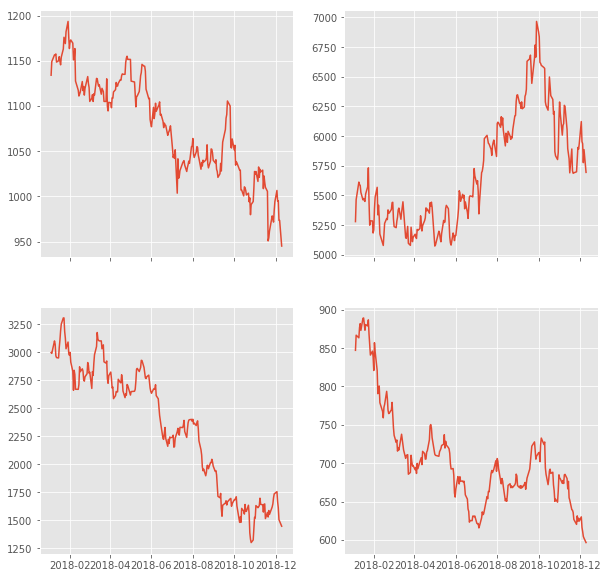

In [5]:
# 3. 各銘柄の[終値調整値]をプロットしてください。

# 3-1. バラでプロットする

fig, axes = plt.subplots(2,2, figsize=(10,10), sharex=True, )

axes[0,0].plot(df_nissan['adj_close'])
axes[0,1].plot(df_sony['adj_close'])
axes[1,0].plot(df_sumco['adj_close'])
axes[1,1].plot(df_mufj['adj_close'])

# だれか、subplots の x軸ラベルをいっぺんに rotation する方法おしえて



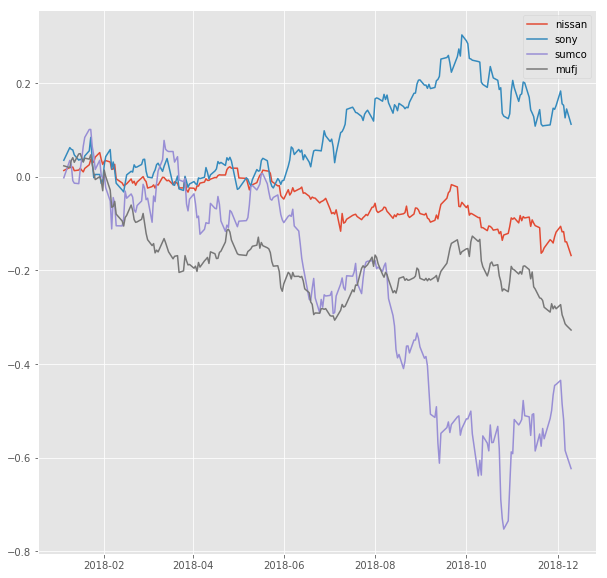

In [6]:
# 3-2. 一つのフレーム内でプロット

# dataの水準が違うので、前日比の積算をして描画

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(df_nissan['adj_close'].pct_change().cumsum(), label='nissan')
ax.plot(df_sony['adj_close'].pct_change().cumsum(), label='sony')
ax.plot(df_sumco['adj_close'].pct_change().cumsum(), label='sumco')
ax.plot(df_mufj['adj_close'].pct_change().cumsum(), label='mufj')
ax.legend()

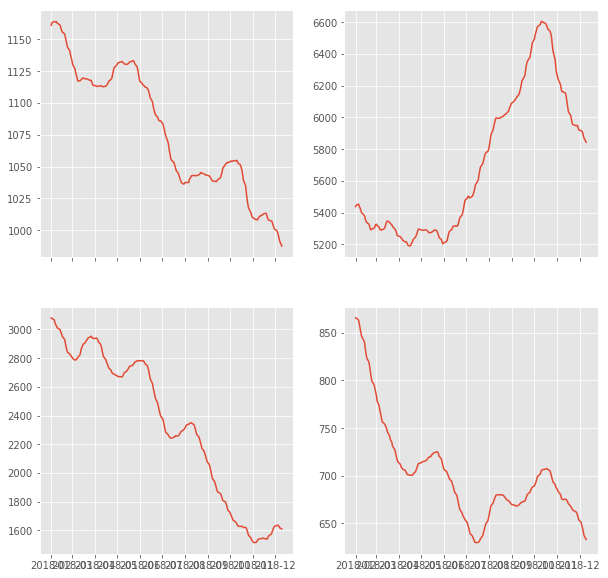

In [7]:
# 3. 各銘柄の[終値調整値]の移動平均をプロットしてください。

fig, axes = plt.subplots(2,2, figsize=(10,10), sharex=True, )

n = 20
axes[0,0].plot(df_nissan['adj_close'].rolling(window=n).mean())
axes[0,1].plot(df_sony['adj_close'].rolling(window=n).mean())
axes[1,0].plot(df_sumco['adj_close'].rolling(window=n).mean())
axes[1,1].plot(df_mufj['adj_close'].rolling(window=n).mean())


In [8]:
# 5. お好きな分析指標を使ってsimulation をしてください。
# ただしHLバンドをする場合は、高値と安値は、終値調整値で調整してください。

# ここからは好きな方法でsimulation 作ってください。
# いくつか私の方で書いたsimulation を載せます。

# まずは終値のみのデータフレームを作る
df_close = pd.DataFrame({'nissan':df_nissan['adj_close'], 
                         'sony':df_sony['adj_close'], 
                         'sumco':df_sumco['adj_close'], 
                         'mufj':df_mufj['adj_close'], 
                        })

df_close.head()

,mufj,nissan,sony,sumco
datetime,,,,
2018-01-04,847.1,1134.0,5279,2996
2018-01-05,866.8,1149.0,5464,2989
2018-01-09,863.4,1156.5,5612,3100
2018-01-10,876.8,1156.5,5591,3070
2018-01-11,881.9,1157.5,5584,2967


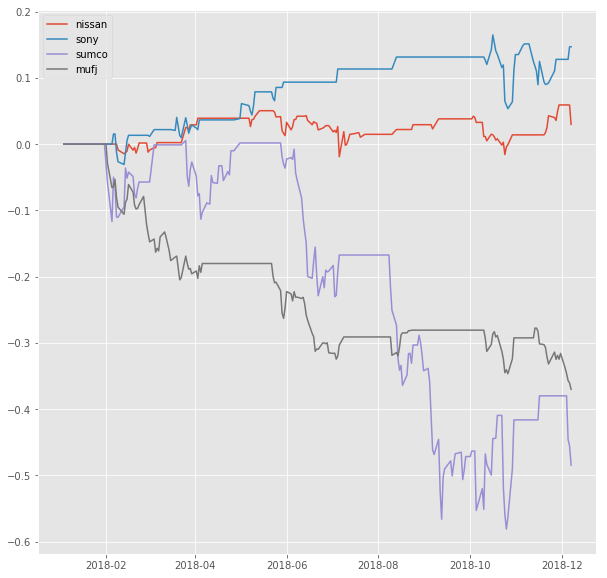

In [9]:
# 移動平均 simulation 
# 移動平均を使った戦略は色々ありますが、勉強した内容の
# [close価格が maより-1.1％以下にある場合、ロングポジション]
# という戦略にしたいとおもいます。

# まずは収益率計算
df_return = df_close.pct_change().shift(-1)

# 20日移動平均を作る
df_ma = df_close.rolling(window=20).mean()
# 移動平均と終値のdiffを作る
df_diff = df_close / df_ma - 1
# -1.1％以下のフラグを作る
df_flag = df_diff < -0.011

df_simulation = df_return * df_flag

# plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(df_simulation['nissan'].cumsum())
ax.plot(df_simulation['sony'].cumsum())
ax.plot(df_simulation['sumco'].cumsum())
ax.plot(df_simulation['mufj'].cumsum())
ax.legend()


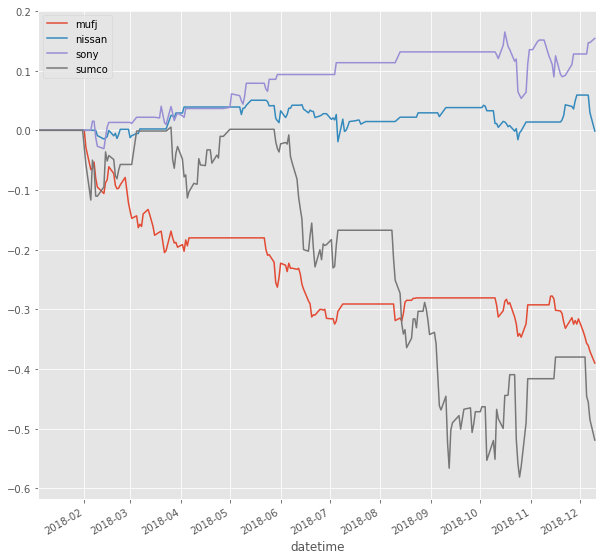

In [9]:
# ちなみに、plot は一行で書く方法もあります。
df_simulation.cumsum().plot(figsize=(10,10))

In [20]:
# 次に、
# 上のsimulation にもうひとつ条件をいれて、
#１０日間ホールドする、というオプションを入れて 関数化してみます。
# この方法は、for を回すところですごく時間がかかり好きではありませんが
# 他の方法を思いつきませんでした。だれか教えてくださいm(_ _)m

def sma_simulation(df_close, window=20, thred=-0.011, hold=10):
    """
    df_close: 終値のDataFrame
    symbol_name: 銘柄名
    window: 移動平均を計算する期間
    thred: 乖離の距離
    hold: 銘柄保有期間
    """
    # 移動平均を作る
    df_ma = df_close.rolling(window=window).mean()
    # 移動平均と今日の終値がどのくらい離れているか確認する
    df_diff = df_close / df_ma - 1
    # それがしきい値より小さいか？
    df_flag = df_diff < thred

    # 指定期間ホールドするためのDataFrameを作成。
    df_holding = pd.DataFrame(data=False, index=df_close.index, columns=df_close.columns)

    # 収益率
    df_return = df_close.pct_change().shift(-1)
    
    # 各銘柄 Seriesとしてデータ取得
    for symbol in df_flag.columns:
        s = df_flag[symbol]
        # Trueが入っている日だけを取得
        flag_dates = s[s].index
        
        # flag_datesの各日に対して、
        for date in flag_dates:
            #その日から10日間Trueを入れる
            df_holding.loc[date:].head(hold)[symbol] = True 
            
        
    df_simulation = df_return * df_holding
    return df_simulation 


In [22]:
df_simulation = sma_simulation(df_close)

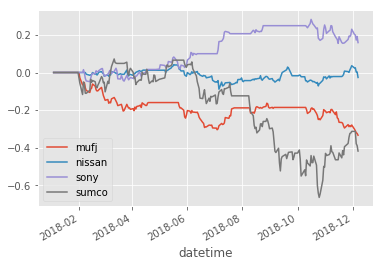

In [23]:
df_simulation.cumsum().plot()